In [1]:
%matplotlib inline
import numpy as np
import time
import torch
from torch import nn, optim
import matplotlib.pyplot as plt

def get_data_ch7():  # 本函数已保存在d2lzh_pytorch包中方便以后使用
    data = np.genfromtxt('../data/airfoil_self_noise.dat', delimiter='\t')
    data = (data - data.mean(axis=0)) / data.std(axis=0)
    return torch.tensor(data[:1500, :-1], dtype=torch.float32), \
    torch.tensor(data[:1500, -1], dtype=torch.float32) # 前1500个样本(每个样本5个特征)

features, labels = get_data_ch7()
features.shape # torch.Size([1500, 5])

torch.Size([1500, 5])

# **AdaGrad优化算法**

In [2]:
def init_adagrad_states():
    s_w = torch.zeros((features.shape[1], 1), dtype=torch.float32)
    s_b = torch.zeros(1, dtype=torch.float32)
    return (s_w, s_b)

def adagrad(params, states, hyperparams):
    eps = 1e-6
    for p, s in zip(params, states):
        s.data += (p.grad.data**2)
        p.data -= hyperparams['lr'] * p.grad.data / torch.sqrt(s + eps)

**模型**

In [5]:
def train_ch7(optimizer_fn, states, hyperparams, features, labels,
              batch_size=10, num_epochs=2):
    # 初始化模型
    net, loss = linreg, squared_loss

    w = torch.nn.Parameter(torch.tensor(np.random.normal(0, 0.01, size=(features.shape[1], 1)), dtype=torch.float32),
                           requires_grad=True)
    b = torch.nn.Parameter(torch.zeros(1, dtype=torch.float32), requires_grad=True)

    def eval_loss():
        return loss(net(features, w, b), labels).mean().item()

    ls = [eval_loss()]
    data_iter = torch.utils.data.DataLoader(
        torch.utils.data.TensorDataset(features, labels), batch_size, shuffle=True)

    for _ in range(num_epochs):
        start = time.time()
        for batch_i, (X, y) in enumerate(data_iter):
            l = loss(net(X, w, b), y).mean()  # 使用平均损失

            # 梯度清零
            if w.grad is not None:
                w.grad.data.zero_()
                b.grad.data.zero_()

            l.backward()
            optimizer_fn([w, b], states, hyperparams)  # 迭代模型参数
            if (batch_i + 1) * batch_size % 100 == 0:
                ls.append(eval_loss())  # 每100个样本记录下当前训练误差
    # 打印结果和作图
    print('loss: %f, %f sec per epoch' % (ls[-1], time.time() - start))
    plt.plot(np.linspace(0, num_epochs, len(ls)), ls)
    plt.xlabel('epoch')
    plt.ylabel('loss')

In [6]:
def linreg(X, w, b):  # 本函数已保存在d2lzh_pytorch包中方便以后使用
    return torch.mm(X, w) + b
def squared_loss(y_hat, y):  # 本函数已保存在d2lzh_pytorch包中方便以后使用
    # 注意这里返回的是向量, 另外, pytorch里的MSELoss并没有除以 2
    return (y_hat - y.view(y_hat.size())) ** 2 / 2

loss: 0.243568, 0.046888 sec per epoch


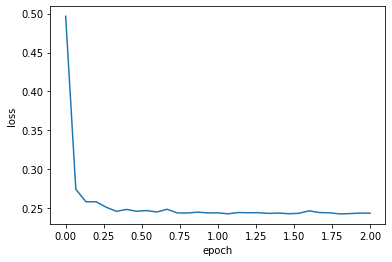

In [7]:
train_ch7(adagrad, init_adagrad_states(), {'lr': 0.1}, features, labels)

**使用优化器**

In [9]:
def train_pytorch_ch7(optimizer_fn, optimizer_hyperparams, features, labels,
                    batch_size=10, num_epochs=2):
    # 初始化模型
    net = nn.Sequential(
        nn.Linear(features.shape[-1], 1)
    )
    loss = nn.MSELoss()
    optimizer = optimizer_fn(net.parameters(), **optimizer_hyperparams)

    def eval_loss():
        return loss(net(features).view(-1), labels).item() / 2

    ls = [eval_loss()]
    data_iter = torch.utils.data.DataLoader(
        torch.utils.data.TensorDataset(features, labels), batch_size, shuffle=True)

    for _ in range(num_epochs):
        start = time.time()
        for batch_i, (X, y) in enumerate(data_iter):
            # 除以2是为了和train_ch7保持一致, 因为squared_loss中除了2
            l = loss(net(X).view(-1), y) / 2 

            optimizer.zero_grad()
            l.backward()
            optimizer.step()
            if (batch_i + 1) * batch_size % 100 == 0:
                ls.append(eval_loss())
    # 打印结果和作图
    print('loss: %f, %f sec per epoch' % (ls[-1], time.time() - start))
    plt.plot(np.linspace(0, num_epochs, len(ls)), ls)
    plt.xlabel('epoch')
    plt.ylabel('loss')

loss: 0.243896, 0.047121 sec per epoch


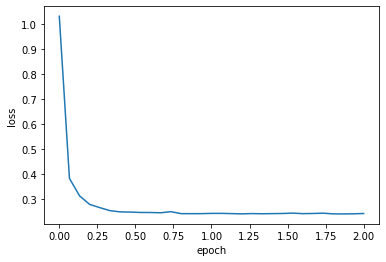

In [10]:
train_pytorch_ch7(torch.optim.Adagrad, {'lr': 0.1}, features, labels)

# RMSProp

In [11]:
def init_rmsprop_states():
    s_w = torch.zeros((features.shape[1], 1), dtype=torch.float32)
    s_b = torch.zeros(1, dtype=torch.float32)
    return (s_w, s_b)

def rmsprop(params, states, hyperparams):
    gamma, eps = hyperparams['gamma'], 1e-6
    for p, s in zip(params, states):
        s.data = gamma * s.data + (1 - gamma) * (p.grad.data)**2
        p.data -= hyperparams['lr'] * p.grad.data / torch.sqrt(s + eps)

loss: 0.243197, 0.052926 sec per epoch


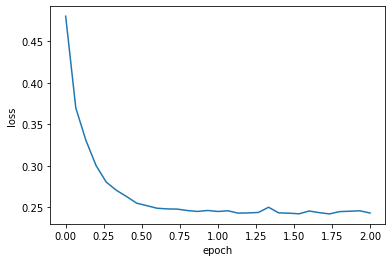

In [12]:
train_ch7(rmsprop, init_rmsprop_states(), {'lr': 0.01, 'gamma': 0.9},
              features, labels)

loss: 0.243702, 0.065916 sec per epoch


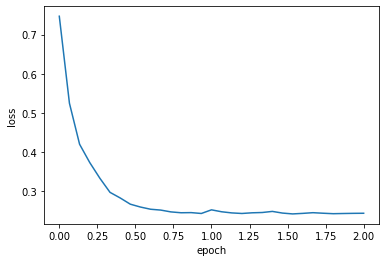

In [13]:
train_pytorch_ch7(torch.optim.RMSprop, {'lr': 0.01, 'alpha': 0.9},
                    features, labels)

# adaDelta

In [14]:
def init_adadelta_states():
    s_w, s_b = torch.zeros((features.shape[1], 1), dtype=torch.float32), torch.zeros(1, dtype=torch.float32)
    delta_w, delta_b = torch.zeros((features.shape[1], 1), dtype=torch.float32), torch.zeros(1, dtype=torch.float32)
    return ((s_w, delta_w), (s_b, delta_b))

def adadelta(params, states, hyperparams):
    rho, eps = hyperparams['rho'], 1e-5
    for p, (s, delta) in zip(params, states):
        s[:] = rho * s + (1 - rho) * (p.grad.data**2)
        g =  p.grad.data * torch.sqrt((delta + eps) / (s + eps))
        p.data -= g
        delta[:] = rho * delta + (1 - rho) * g * g

loss: 0.243212, 0.078150 sec per epoch


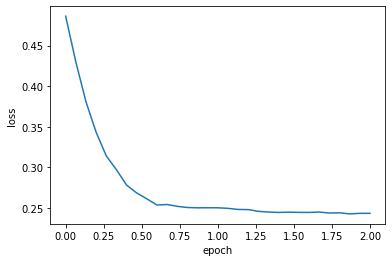

In [15]:
train_ch7(adadelta, init_adadelta_states(), {'rho': 0.9}, features, labels)

loss: 0.256759, 0.057579 sec per epoch


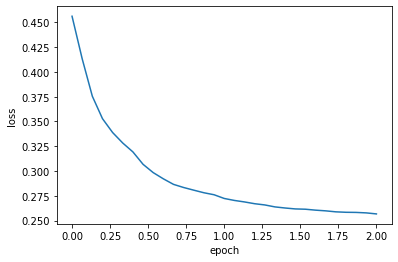

In [16]:
train_pytorch_ch7(torch.optim.Adadelta, {'rho': 0.9}, features, labels)

# Adam

In [17]:
def init_adam_states():
    v_w, v_b = torch.zeros((features.shape[1], 1), dtype=torch.float32), torch.zeros(1, dtype=torch.float32)
    s_w, s_b = torch.zeros((features.shape[1], 1), dtype=torch.float32), torch.zeros(1, dtype=torch.float32)
    return ((v_w, s_w), (v_b, s_b))

def adam(params, states, hyperparams):
    beta1, beta2, eps = 0.9, 0.999, 1e-6
    for p, (v, s) in zip(params, states):
        v[:] = beta1 * v + (1 - beta1) * p.grad.data
        s[:] = beta2 * s + (1 - beta2) * p.grad.data**2
        v_bias_corr = v / (1 - beta1 ** hyperparams['t'])
        s_bias_corr = s / (1 - beta2 ** hyperparams['t'])
        p.data -= hyperparams['lr'] * v_bias_corr / (torch.sqrt(s_bias_corr) + eps)
    hyperparams['t'] += 1

loss: 0.242236, 0.067152 sec per epoch


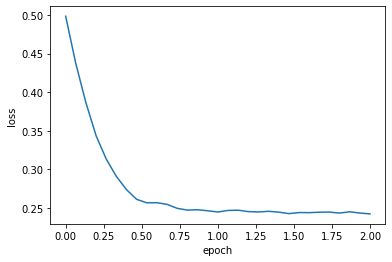

In [18]:
train_ch7(adam, init_adam_states(), {'lr': 0.01, 't': 1}, features, labels)

loss: 0.244342, 0.052292 sec per epoch


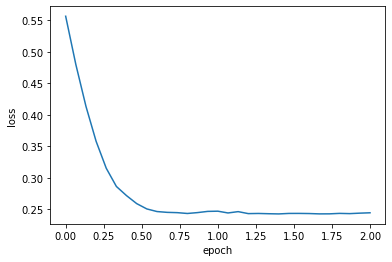

In [19]:
train_pytorch_ch7(torch.optim.Adam, {'lr': 0.01}, features, labels)